In [158]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import os
import random
from collections import Counter

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
from nltk.tokenize import word_tokenize


from torch.utils.data import Dataset
import os
from PIL import Image
import nltk
from torchvision import transforms
from collections import Counter
from nltk.tokenize import word_tokenize
import torch
from torch.nn.functional import pad

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [159]:

import os
import random
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.nn.functional import pad

nltk.download('punkt')

class Flickr8kDataset(Dataset):
    def __init__(self, img_paths, captions, transform=None, max_length=50):
        self.img_paths = img_paths
        self.captions = captions
        self.transform = transform
        self.vocab, self.index_to_word = self.build_vocab(self.captions)  # Store both vocab and reverse mapping
        self.vocab_size = len(self.vocab)
        self.max_length = max_length

    def build_vocab(self, captions):
        counter = Counter()
        for caption in captions:
            tokens = word_tokenize(caption.lower())
            counter.update(tokens)
        # Start IDs from 4 because 0-3 are reserved for special tokens
        vocab = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        index_to_word = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}
        offset = len(vocab)
        for idx, (word, _) in enumerate(counter.most_common()):
            vocab[word] = idx + offset
            index_to_word[idx + offset] = word
        return vocab, index_to_word

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        caption = self.captions[index]
        tokens = word_tokenize(caption.lower())
        caption_ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        caption_ids.append(self.vocab['<END>'])  # Add <END> token at the end
        caption_tensor = torch.tensor(caption_ids)
        length = len(caption_tensor)  # Get the actual length before padding
        padded_caption = pad(caption_tensor, (0, self.max_length - length), 'constant', self.vocab['<PAD>'])
        return img, padded_caption, length  # Return length for use in training

    def __len__(self):
        return len(self.img_paths)

# Clean up special tokens from the captions
def clean_caption(caption):
    tokens = word_tokenize(caption.lower())
    cleaned_tokens = [token for token in tokens if token.isalnum()]
    return ' '.join(cleaned_tokens)

# Image transformations for ResNet-50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load image paths and captions
image_dir = 'Images'
caption_file = 'captions.txt'
img_paths = []
captions = []

with open(caption_file, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split(',')
        if len(parts) == 2 and parts[1].strip():  # Check if caption is not empty
            img_name, caption = parts
            img_path = os.path.join(image_dir, img_name.strip())
            if os.path.exists(img_path):
                img_paths.append(img_path)
                cleaned_caption = clean_caption(caption.strip())
                captions.append(cleaned_caption)
import copy
original_captions = copy.deepcopy(captions)
# Initialize dataset with transformations
dataset = Flickr8kDataset(img_paths, captions, transform=transform)
# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders for batching
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [160]:

class Encoder(nn.Module):  # Define the Encoder class, inheriting from nn.Module
    def __init__(self, encoded_image_size=14):  # Initialize the Encoder class with a default encoded image size of 14
        super(Encoder, self).__init__()  # Call the parent class's constructor
        self.enc_image_size = encoded_image_size  # Set the encoded image size

        resnet = torchvision.models.resnet101(pretrained=True)  # Load a pretrained ResNet-101 model
        modules = list(resnet.children())[:-2]  # Remove the last two layers of the ResNet model
        self.resnet = nn.Sequential(*modules)  # Create a new sequential model with the modified ResNet
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))  # Define an adaptive average pooling layer
        self.fine_tune()  # Call the fine-tune method to set parameters

    def forward(self, images):  # Define the forward pass for the Encoder
        out = self.resnet(images)  # Pass the images through the ResNet model
        out = self.adaptive_pool(out)  # Apply adaptive average pooling
        out = out.permute(0, 2, 3, 1)  # Change the order of dimensions
        return out  # Return the output

    def fine_tune(self, fine_tune=True):  # Define the fine-tune method to allow parameter updating
        for p in self.resnet.parameters():  # Iterate over all parameters in the ResNet model
            p.requires_grad = False  # Disable gradient computation for all parameters
        for c in list(self.resnet.children())[5:]:  # Iterate over specific layers of the ResNet model
            for p in c.parameters():  # Iterate over parameters in these layers
                p.requires_grad = fine_tune  # Enable gradient computation based on the fine_tune argument

class Attention(nn.Module):  # Define the Attention class, inheriting from nn.Module
    def __init__(self, encoder_dim, decoder_dim, attention_dim):  # Initialize the Attention class with dimensions
        super(Attention, self).__init__()  # Call the parent class's constructor
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Linear layer to transform encoder output
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Linear layer to transform decoder hidden state
        self.full_att = nn.Linear(attention_dim, 1)  # Linear layer to compute attention scores
        self.relu = nn.ReLU()  # ReLU activation function
        self.softmax = nn.Softmax(dim=1)  # Softmax function to get attention weights

    def forward(self, encoder_out, decoder_hidden):  # Define the forward pass for the Attention
        att1 = self.encoder_att(encoder_out)  # Transform encoder output
        att2 = self.decoder_att(decoder_hidden)  # Transform decoder hidden state
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # Compute attention scores
        alpha = self.softmax(att)  # Apply softmax to get attention weights
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # Compute the context vector
        return attention_weighted_encoding, alpha  # Return the context vector and attention weights

class DecoderWithAttention(nn.Module):  # Define the DecoderWithAttention class, inheriting from nn.Module
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):  # Initialize the class
        super(DecoderWithAttention, self).__init__()  # Call the parent class's constructor
        self.encoder_dim = encoder_dim  # Set the encoder dimension
        self.attention_dim = attention_dim  # Set the attention dimension
        self.embed_dim = embed_dim  # Set the embedding dimension
        self.decoder_dim = decoder_dim  # Set the decoder dimension
        self.vocab_size = vocab_size  # Set the vocabulary size
        self.dropout = dropout  # Set the dropout rate

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # Initialize the Attention layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Define the embedding layer
        self.dropout = nn.Dropout(p=self.dropout)  # Define the dropout layer
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # Define the LSTM cell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # Linear layer to initialize hidden state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # Linear layer to initialize cell state
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # Linear layer to create a gate
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function
        self.fc = nn.Linear(decoder_dim, vocab_size)  # Fully connected layer to predict the next word
        self.init_weights()  # Initialize the weights

    def init_weights(self):  # Method to initialize weights
        self.embedding.weight.data.uniform_(-0.1, 0.1)  # Initialize embedding weights
        self.fc.bias.data.fill_(0)  # Initialize fully connected layer bias
        self.fc.weight.data.uniform_(-0.1, 0.1)  # Initialize fully connected layer weights

    def load_pretrained_embeddings(self, embeddings):  # Method to load pretrained embeddings
        self.embedding.weight = nn.Parameter(embeddings)  # Set the embedding weights to the pretrained embeddings

    def fine_tune_embeddings(self, fine_tune=True):  # Method to allow fine-tuning of embeddings
        for p in self.embedding.parameters():  # Iterate over all embedding parameters
            p.requires_grad = fine_tune  # Set requires_grad based on the fine_tune argument

    def init_hidden_state(self, encoder_out):  # Method to initialize hidden states
        mean_encoder_out = encoder_out.mean(dim=1)  # Compute the mean of the encoder output
        h = self.init_h(mean_encoder_out)  # Initialize hidden state
        c = self.init_c(mean_encoder_out)  # Initialize cell state
        return h, c  # Return hidden and cell states

    def forward(self, encoder_out, encoded_captions, caption_lengths):  # Define the forward pass for the DecoderWithAttention
        batch_size = encoder_out.size(0)  # Get the batch size
        encoder_dim = encoder_out.size(-1)  # Get the encoder dimension
        vocab_size = self.vocab_size  # Get the vocabulary size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # Reshape encoder output
        num_pixels = encoder_out.size(1)  # Get the number of pixels

        # Sort input data by decreasing lengths
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)  # Sort caption lengths and get sort indices
        encoder_out = encoder_out[sort_ind]  # Reorder encoder output
        encoded_captions = encoded_captions[sort_ind]  # Reorder encoded captions

        embeddings = self.embedding(encoded_captions)  # Embed the encoded captions

        h, c = self.init_hidden_state(encoder_out)  # Initialize hidden states

        decode_lengths = (caption_lengths - 1).tolist()  # Get decode lengths

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size)  # Initialize predictions tensor
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels)  # Initialize alphas tensor
        for t in range(max(decode_lengths)):  # Iterate over time steps
            batch_size_t = sum([l > t for l in decode_lengths])  # Compute batch size for the current time step
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], h[:batch_size_t]
            )  # Get attention weighted encoding and alphas
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # Compute the gate value
            attention_weighted_encoding = gate * attention_weighted_encoding  # Apply the gate to the attention weighted encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]),
            )  # Update hidden and cell states
            preds = self.fc(self.dropout(h))  # Compute predictions
            predictions[:batch_size_t, t, :] = preds  # Store predictions
            alphas[:batch_size_t, t, :] = alpha  # Store alphas

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind  # Return predictions, encoded captions, decode lengths, alphas, and sort indices



In [138]:
### Without .to(devicee)

print("hello")

def save_model(epoch, encoder, decoder, optimizer, val_loss, filename):
    torch.save({
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }, filename)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
embed_size = 512
attention_dim = 512
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 1
dropout = 0.5
encoder_dim = 2048
learning_rate = 0.001
num_epochs = 10

# Initialize the encoder and decoder
encoder = Encoder()
decoder = DecoderWithAttention(attention_dim, embed_size, hidden_size, vocab_size, encoder_dim, dropout)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=learning_rate)

def evaluate_model(loader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions, lengths in loader:
            lengths, sort_ind = lengths.sort(dim=0, descending=True)
            images, captions = images[sort_ind], captions[sort_ind]

            features = encoder(images)
            outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

            targets = caps_sorted[:, 1:]

            outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training loop
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    for i, (images, captions, lengths) in enumerate(train_loader):
        lengths, sort_ind = lengths.sort(dim=0, descending=True)
        images, captions = images[sort_ind], captions[sort_ind]

        optimizer.zero_grad()
        features = encoder(images)
        outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

        targets = caps_sorted[:, 1:]

        outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Validation phase
    val_loss = evaluate_model(val_loader, encoder, decoder, criterion)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss:.4f}')

    # Save the model checkpoint
    save_model(epoch, encoder, decoder, optimizer, val_loss, f'model_epoch_{epoch+1}_valloss_{val_loss:.4f}.pth')

# Testing phase
test_loss = evaluate_model(test_loader, encoder, decoder, criterion)
print(f'Test Loss: {test_loss:.4f}')

print('Finished Training')


hello
Epoch [1/10], Step [100/951], Loss: 4.8206
Epoch [1/10], Step [200/951], Loss: 4.3453
Epoch [1/10], Step [300/951], Loss: 4.0146
Epoch [1/10], Step [400/951], Loss: 3.6816
Epoch [1/10], Step [500/951], Loss: 3.8371
Epoch [1/10], Step [600/951], Loss: 3.9368
Epoch [1/10], Step [700/951], Loss: 3.7760
Epoch [1/10], Step [800/951], Loss: 3.6219
Epoch [1/10], Step [900/951], Loss: 3.4770
Epoch [1/10] Validation Loss: 3.5443
Epoch [2/10], Step [100/951], Loss: 3.7527
Epoch [2/10], Step [200/951], Loss: 3.3051
Epoch [2/10], Step [300/951], Loss: 3.7387
Epoch [2/10], Step [400/951], Loss: 3.1250
Epoch [2/10], Step [500/951], Loss: 3.1498
Epoch [2/10], Step [600/951], Loss: 3.5169
Epoch [2/10], Step [700/951], Loss: 3.6293
Epoch [2/10], Step [800/951], Loss: 3.7552
Epoch [2/10], Step [900/951], Loss: 3.6768
Epoch [2/10] Validation Loss: 3.3156
Epoch [3/10], Step [100/951], Loss: 3.0864
Epoch [3/10], Step [200/951], Loss: 3.3057
Epoch [3/10], Step [300/951], Loss: 2.9871
Epoch [3/10], Ste

KeyboardInterrupt: 

In [175]:
## Continue training on saved model

import torch
import torch.nn as nn

# Assume Encoder and DecoderWithAttention classes are defined elsewhere

def load_checkpoint(filepath, dataset, learning_rate=0.001):
    checkpoint = torch.load(filepath)
    # Manually set the parameters if they are not in the checkpoint
    attention_dim = 512
    embed_size = 512
    hidden_size = 512
    vocab_size = len(dataset.vocab)
    encoder_dim = 2048
    dropout = 0.5
    
    encoder = Encoder()
    decoder = DecoderWithAttention(
        attention_dim=attention_dim,
        embed_dim=embed_size,
        decoder_dim=hidden_size,
        vocab_size=vocab_size,
        encoder_dim=encoder_dim,
        dropout=dropout
    )
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
    optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=learning_rate)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    
    return encoder, decoder, optimizer, epoch, val_loss

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
embed_size = 512
attention_dim = 512
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 1
dropout = 0.5
encoder_dim = 2048
learning_rate = 0.001
num_epochs = 10

# Initialize the encoder and decoder
encoder = Encoder()
decoder = DecoderWithAttention(attention_dim, embed_size, hidden_size, vocab_size, encoder_dim, dropout)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=learning_rate)

# Load the saved model if exists
start_epoch = 5
saved_model_filename = 'model_epoch_5_valloss_2.8108.pth'  # Update with your saved model filename
if saved_model_filename:
    encoder, decoder, optimizer, _ , _ = load_checkpoint(saved_model_filename, dataset, learning_rate)
    print(f"Resuming training on epoch {start_epoch+1}")

def evaluate_model(loader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions, lengths in loader:
            lengths, sort_ind = lengths.sort(dim=0, descending=True)
            images, captions = images[sort_ind], captions[sort_ind]

            features = encoder(images)
            outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

            targets = caps_sorted[:, 1:]

            outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training loop
for epoch in range(start_epoch, num_epochs):
    encoder.train()
    decoder.train()
    for i, (images, captions, lengths) in enumerate(train_loader):
        lengths, sort_ind = lengths.sort(dim=0, descending=True)
        images, captions = images[sort_ind], captions[sort_ind]

        optimizer.zero_grad()
        features = encoder(images)
        outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

        targets = caps_sorted[:, 1:]

        outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Validation phase
    val_loss = evaluate_model(val_loader, encoder, decoder, criterion)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss:.4f}')

    # Save the model checkpoint
    save_model(epoch, encoder, decoder, optimizer, val_loss, f'model_epoch_{epoch+1}_valloss_{val_loss:.4f}.pth')

# Testing phase
test_loss = evaluate_model(test_loader, encoder, decoder, criterion)
print(f'Test Loss: {test_loss:.4f}')

print('Finished Training')


Resuming training on epoch 6
Epoch [6/10], Step [100/951], Loss: 2.6410
Epoch [6/10], Step [200/951], Loss: 2.5878
Epoch [6/10], Step [300/951], Loss: 2.6987
Epoch [6/10], Step [400/951], Loss: 2.8613
Epoch [6/10], Step [500/951], Loss: 2.5764
Epoch [6/10], Step [600/951], Loss: 2.7390
Epoch [6/10], Step [700/951], Loss: 2.5698
Epoch [6/10], Step [800/951], Loss: 2.7291
Epoch [6/10], Step [900/951], Loss: 2.7357
Epoch [6/10] Validation Loss: 2.8020
Epoch [7/10], Step [100/951], Loss: 2.5103
Epoch [7/10], Step [200/951], Loss: 2.6157
Epoch [7/10], Step [300/951], Loss: 2.5433
Epoch [7/10], Step [400/951], Loss: 2.5535
Epoch [7/10], Step [500/951], Loss: 2.4566
Epoch [7/10], Step [600/951], Loss: 2.5234
Epoch [7/10], Step [700/951], Loss: 2.4114
Epoch [7/10], Step [800/951], Loss: 2.4954
Epoch [7/10], Step [900/951], Loss: 2.5459
Epoch [7/10] Validation Loss: 2.8100
Epoch [8/10], Step [100/951], Loss: 2.2389
Epoch [8/10], Step [200/951], Loss: 2.4709
Epoch [8/10], Step [300/951], Loss: 2

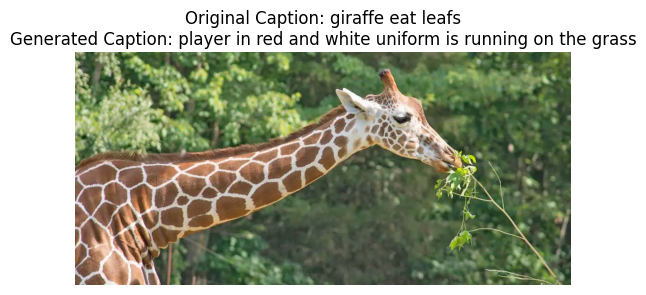

In [225]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    # Manually set the parameters if they are not in the checkpoint
    attention_dim = 512
    embed_size = 512
    hidden_size = 512
    vocab_size = len(dataset.vocab)
    encoder_dim = 2048
    dropout = 0.5
    
    encoder = Encoder()
    decoder = DecoderWithAttention(
        attention_dim=attention_dim,
        embed_dim=embed_size,
        decoder_dim=hidden_size,
        vocab_size=vocab_size,
        encoder_dim=encoder_dim,
        dropout=dropout
    )
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    return encoder, decoder

def generate_caption(image_path, encoder, decoder, vocab, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        features = encoder(image)
        features = features.view(1, -1, features.size(-1))  # Flatten the features
        h, c = decoder.init_hidden_state(features)

        start_token = torch.tensor([vocab['<START>']]).unsqueeze(0).to(device)
        inputs = start_token

        caption = []
        for _ in range(dataset.max_length):
            embeddings = decoder.embedding(inputs).squeeze(1)
            attention_weighted_encoding, alpha = decoder.attention(features, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = decoder.decode_step(
                torch.cat([embeddings, attention_weighted_encoding.squeeze(1)], dim=1),
                (h, c)
            )
            output = decoder.fc(h)
            _, predicted = output.max(1)
            inputs = predicted.unsqueeze(0)

            word = dataset.index_to_word[predicted.item()]
            if word == '<END>':
                break
            caption.append(word)

    return ' '.join(caption)

def show_image_with_captions(image_path, original_caption, generated_caption):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Original Caption: {original_caption}\nGenerated Caption: {generated_caption}")
    plt.show()

# Load the model checkpoint
encoder, decoder = load_checkpoint('model_epoch_6_valloss_2.8020.pth')
encoder = encoder.to(device)
decoder = decoder.to(device)

# Example usage
image_path = 'gel2.jpg'
original_caption = "giraffe eat leafs"
generated_caption = generate_caption(image_path, encoder, decoder, dataset.vocab, transform)

show_image_with_captions(image_path, original_caption, generated_caption)


In [134]:
##Training with .to(device)
print("hello")

def save_model(epoch, encoder, decoder, optimizer, val_loss, filename):
    torch.save({
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }, filename)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
embed_size = 512
attention_dim = 512
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 1
dropout = 0.5
encoder_dim = 2048
learning_rate = 0.001
num_epochs = 10

# Initialize the encoder and decoder
encoder = Encoder().to(device)
decoder = DecoderWithAttention(attention_dim, embed_size, hidden_size, vocab_size, encoder_dim, dropout).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=learning_rate)

def evaluate_model(loader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions, lengths in loader:
            images, captions = images.to(device), captions.to(device)
            lengths, sort_ind = lengths.sort(dim=0, descending=True)
            images, captions = images[sort_ind], captions[sort_ind]

            features = encoder(images)
            outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

            targets = caps_sorted[:, 1:]

            outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training loop
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    for i, (images, captions, lengths) in enumerate(train_loader):
        images, captions = images.to(device), captions.to(device)
        lengths, sort_ind = lengths.sort(dim=0, descending=True)
        images, captions = images[sort_ind], captions[sort_ind]

        optimizer.zero_grad()
        features = encoder(images)
        outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

        targets = caps_sorted[:, 1:]

        outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Validation phase
    val_loss = evaluate_model(val_loader, encoder, decoder, criterion)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss:.4f}')

    # Save the model checkpoint
    save_model(epoch, encoder, decoder, optimizer, val_loss, f'model_epoch_{epoch+1}_valloss_{val_loss:.4f}.pth')

# Testing phase
test_loss = evaluate_model(test_loader, encoder, decoder, criterion)
print(f'Test Loss: {test_loss:.4f}')

print('Finished Training')




hello


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

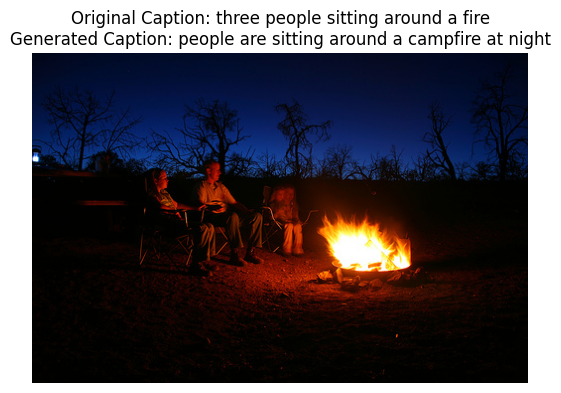

In [217]:
##LOAD MODEL AND DISPLAY OUTPUT

import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.models as models
import torch.nn as nn
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    # Manually set the parameters if they are not in the checkpoint
    attention_dim = 512
    embed_size = 512
    hidden_size = 512
    vocab_size = len(dataset.vocab)
    encoder_dim = 2048
    dropout = 0.5
    
    encoder = Encoder()
    decoder = DecoderWithAttention(
        attention_dim=attention_dim,
        embed_dim=embed_size,
        decoder_dim=hidden_size,
        vocab_size=vocab_size,
        encoder_dim=encoder_dim,
        dropout=dropout
    )
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    return encoder, decoder

def generate_caption(image, encoder, decoder, vocab, transform):
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        features = encoder(image)
        features = features.view(1, -1, features.size(-1))  # Flatten the features
        h, c = decoder.init_hidden_state(features)

        start_token = torch.tensor([vocab['<START>']]).unsqueeze(0).to(device)
        inputs = start_token

        caption = []
        for _ in range(dataset.max_length):
            embeddings = decoder.embedding(inputs).squeeze(1)
            attention_weighted_encoding, alpha = decoder.attention(features, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = decoder.decode_step(
                torch.cat([embeddings, attention_weighted_encoding.squeeze(1)], dim=1),
                (h, c)
            )
            output = decoder.fc(h)
            _, predicted = output.max(1)
            inputs = predicted.unsqueeze(0)

            word = dataset.index_to_word[predicted.item()]
            if word == '<END>':
                break
            caption.append(word)

    return ' '.join(caption)

def show_image_with_captions(image, original_caption, generated_caption):
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Original Caption: {original_caption}\nGenerated Caption: {generated_caption}")
    plt.show()

# Load the model checkpoint
encoder, decoder = load_checkpoint('model_epoch_10_valloss_2.8538.pth')
encoder = encoder.to(device)
decoder = decoder.to(device)

# Select a random sample from the dataset
random_idx = random.randint(0, len(dataset) - 1)
image_path = dataset.img_paths[random_idx]
original_caption = original_captions[random_idx]

# Load the image
image = Image.open(image_path).convert("RGB")

# Generate the caption
generated_caption = generate_caption(image, encoder, decoder, dataset.vocab, transform)

# Display the image with captions
show_image_with_captions(image, original_caption, generated_caption)
